In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
device

'cuda'

In [2]:
# Make 1000 samples
n_samples = 10000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [3]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.0464692   0.82477834]
 [ 1.00506323 -0.43335153]
 [-0.58348442  0.79452834]
 [ 0.98478298 -0.32517879]
 [ 0.82993028 -0.54722305]]

First 5 y labels:
[1 0 0 0 0]


In [4]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.046469,0.824778,1
1,1.005063,-0.433352,0
2,-0.583484,0.794528,0
3,0.984783,-0.325179,0
4,0.829930,-0.547223,0
5,-0.133929,0.776249,1
6,0.779197,0.645811,0
7,0.722955,0.173831,1
8,-0.121807,0.796951,1
9,0.849529,0.505678,0


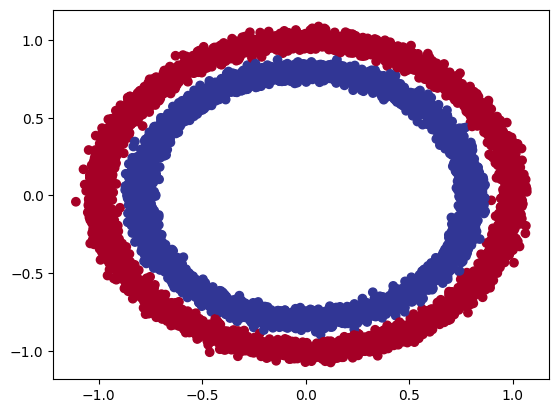

In [5]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [6]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

#move data tensors to CUDA
X = X.to(device)
y = y.to(device)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.0465,  0.8248],
         [ 1.0051, -0.4334],
         [-0.5835,  0.7945],
         [ 0.9848, -0.3252],
         [ 0.8299, -0.5472]], device='cuda:0'),
 tensor([1., 0., 0., 0., 0.], device='cuda:0'))

In [7]:
#code block is to check if cuda is working correctly
test = X.numpy()
test
# cuda doesnt work on laptop ig nvm it DOES.

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [8]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(8000, 2000, 8000, 2000)

In [9]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=10) # takes in 2 features (X), produces 10 features
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1) # takes in 5 features, produces 1 feature (y)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_3(
            self.relu(self.layer_2(
            self.relu(self.layer_1(x))))) #computation goes through layer 1 and the output goes through layer 2

In [10]:
model = CircleModel()
model.to(device)

CircleModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [15]:
# Make predictions with the model (without sigmoid and rounding)
untrained_preds = model(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 2000, Shape: torch.Size([2000, 1])
Length of test samples: 2000, Shape: torch.Size([2000])

First 10 predictions:
tensor([[0.3278],
        [0.3008],
        [0.1765],
        [0.1348],
        [0.2864],
        [0.1850],
        [0.1593],
        [0.1626],
        [0.1344],
        [0.1487]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 1., 0., 1., 0., 1., 1., 1., 1., 1.], device='cuda:0')


In [12]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

In [13]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [14]:
correct = torch.eq(untrained_preds, y_test.to(device)) # stuff to assist my own understanding
correct.sum()

tensor(0, device='cuda:0')

In [36]:
#training loop
model.to(device)
epochs = 1000   # go here: https://www.learnpytorch.io/02_pytorch_classification/#3-train-model
epoch_count = []
train_loss_values = []

X_test, X_train, y_test, y_train = X_test.to(device), X_train.to(device), y_test.to(device), y_train.to(device)
print(X_test.device, X_train.device, y_test.device, y_train.device)
for epoch in range(epochs):
    model.train()
    y_logits = model(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_predictions = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    loss = loss_fn(y_logits, y_train) # calc loss
    acc = accuracy_fn(y_true=y_train, y_pred=y_predictions)
    optimizer.zero_grad() # zero gradients
    loss.backward() # backpropagation
    optimizer.step()

    if epoch % 10 == 0:
        model.eval()
        with torch.inference_mode():
            epoch_count.append(epoch)
            loss1 = loss.cpu()
            train_loss_values.append(loss1.detach().numpy())
            test_predictions = torch.round(torch.sigmoid(model(X_test).squeeze()))
            test_loss = loss_fn(test_predictions, y_test)
            test_acc = accuracy_fn(test_predictions, y_test)
        print(f"Epoch {epoch} | Accuracy: {acc:.2f}% | Loss: {loss:.7f} | Test accuracy: {acc:.2f}%")

cuda:0 cuda:0 cuda:0 cuda:0
Epoch 0 | Accuracy: 99.96% | Loss: 0.0267441 | Test accuracy: 99.96%
Epoch 10 | Accuracy: 99.96% | Loss: 0.0263687 | Test accuracy: 99.96%
Epoch 20 | Accuracy: 99.96% | Loss: 0.0260038 | Test accuracy: 99.96%
Epoch 30 | Accuracy: 99.96% | Loss: 0.0256482 | Test accuracy: 99.96%
Epoch 40 | Accuracy: 99.96% | Loss: 0.0253022 | Test accuracy: 99.96%
Epoch 50 | Accuracy: 99.96% | Loss: 0.0249653 | Test accuracy: 99.96%
Epoch 60 | Accuracy: 99.96% | Loss: 0.0246371 | Test accuracy: 99.96%
Epoch 70 | Accuracy: 99.96% | Loss: 0.0243175 | Test accuracy: 99.96%
Epoch 80 | Accuracy: 99.96% | Loss: 0.0240060 | Test accuracy: 99.96%
Epoch 90 | Accuracy: 99.96% | Loss: 0.0237024 | Test accuracy: 99.96%
Epoch 100 | Accuracy: 99.96% | Loss: 0.0234064 | Test accuracy: 99.96%
Epoch 110 | Accuracy: 99.96% | Loss: 0.0231180 | Test accuracy: 99.96%
Epoch 120 | Accuracy: 99.96% | Loss: 0.0228367 | Test accuracy: 99.96%
Epoch 130 | Accuracy: 99.96% | Loss: 0.0225618 | Test accura

In [18]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


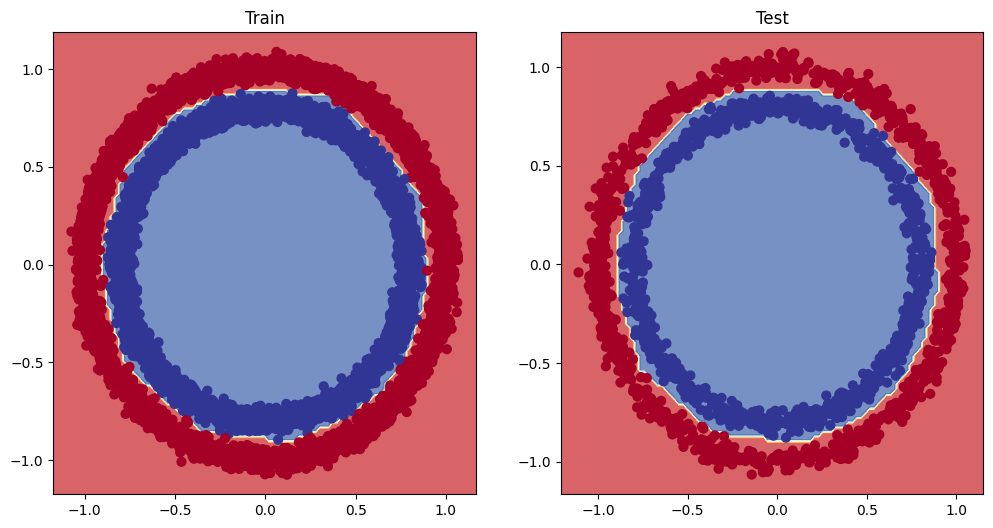

In [22]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

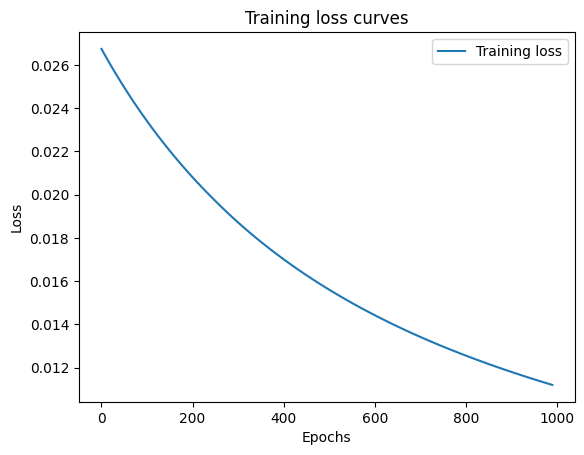

In [37]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Training loss")
#plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])


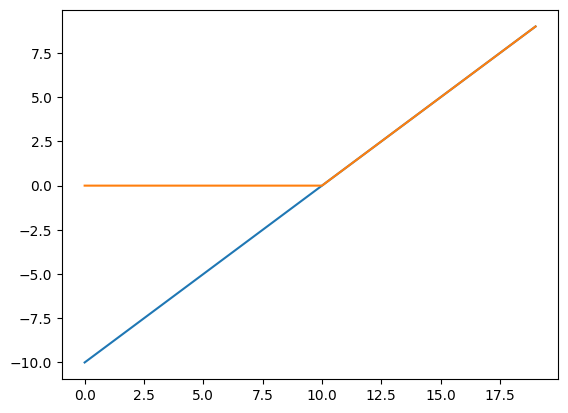

In [34]:
A = torch.arange(-10, 10, 1, dtype=torch.float32).cpu()
plt.plot(A)
# Create ReLU function by hand
def relu(x):
  return torch.maximum(torch.tensor(0).cpu(), x) # inputs must be tensors
print(relu(A))
plt.plot(relu(A))